This notebook does not prep the data.

In [1]:
#Imports
import numpy as np
import pandas as pd
import os
import shutil
import glob
import itertools
import random
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner
from keras_tuner import RandomSearch
from sklearn.metrics import confusion_matrix
from PIL import Image

In [2]:
#Preferences
warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline

In [3]:
#Path variables
train_path = "data/train/"
val_path = "data/val/"
test_path = "data/test/"

In [4]:
path_list = [train_path, val_path, test_path]

In [5]:
datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = datagen.flow_from_directory(directory=train_path,
                                              target_size=(256,256),
                                              batch_size=16,
                                              color_mode="grayscale",
                                              classes=["NORMAL", "viral_pneumonia", "bacterial_pneumonia"],
                                              save_format="jpeg")

Found 5097 images belonging to 3 classes.


In [7]:
val_generator = datagen.flow_from_directory(directory=val_path,
                                            target_size=(256,256),
                                            batch_size=16,
                                            color_mode="grayscale",
                                            classes=["NORMAL", "viral_pneumonia", "bacterial_pneumonia"],
                                            save_format="jpeg")

Found 135 images belonging to 3 classes.


In [8]:
test_generator = datagen.flow_from_directory(directory=test_path,
                                             target_size=(256,256),
                                             batch_size=16,
                                             color_mode="grayscale",
                                             classes=["NORMAL", "viral_pneumonia", "bacterial_pneumonia"],
                                             save_format="jpeg",
                                             shuffle=False)

Found 624 images belonging to 3 classes.


In [9]:
img, labels = next(train_generator)

In [10]:
def build_model(hp):
    """
    Building a model to optimize hypter parameters.
    """
    model = Sequential()
    model.add(Conv2D(filters=hp.Int("conv_1_filter",
                                    min_value=16,
                                    max_value=256,
                                    step=16),
                     kernel_size=hp.Choice("conv_1_kernel", values = [3,5]),
                     activation="relu",
                     input_shape=(256,256,1)))
    model.add(MaxPool2D(pool_size=2))
    model.add(Conv2D(filters=hp.Int("conv_1_filter",
                                    min_value=16,
                                    max_value=256,
                                    step=16),
                     kernel_size=hp.Choice("conv_2_kernel", values = [3,5]),
                     activation="relu"))
    model.add(MaxPool2D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(units=hp.Int("dense_1_units",
                                 min_value=16,
                                 max_value=256,
                                 step=16),
                    activation="relu"))
    model.add(Dense(units=3, activation="softmax"))

    model.compile(optimizer=Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3])),
                  loss="categorical_crossentropy",
                  metrics=["accuracy", tf.keras.metrics.Recall()])

    return model

In [11]:
tuner_search = RandomSearch(build_model,
                            objective="val_accuracy",
                            max_trials=5,
                            directory="output",
                            project_name="ChestXrayPneumoniaAccuracy2")

2023-08-02 10:40:43.548690: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
tuner_search.search(train_generator, epochs=3, validation_data=val_generator)

Trial 5 Complete [05h 57m 37s]
val_accuracy: 0.7481481432914734

Best val_accuracy So Far: 0.7925925850868225
Total elapsed time: 09h 47m 34s
INFO:tensorflow:Oracle triggered exit


In [13]:
model = tuner_search.get_best_models(num_models=1)[0]

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 61504)             0         
                                                                 
 dense (Dense)               (None, 160)               9

In [15]:
""" Best Model so far:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 123, 32)      25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 119072)            0         
                                                                 
 dense (Dense)               (None, 64)                7620672   
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
=================================================================
Total params: 7,646,819
Trainable params: 7,646,819
Non-trainable params: 0
"""

' Best Model so far:\n\nModel: "sequential"\n_________________________________________________________________\n Layer (type)                Output Shape              Param #   \n=================================================================\n conv2d (Conv2D)             (None, 254, 254, 32)      320       \n                                                                 \n max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         \n )                                                               \n                                                                 \n conv2d_1 (Conv2D)           (None, 123, 123, 32)      25632     \n                                                                 \n max_pooling2d_1 (MaxPooling  (None, 61, 61, 32)       0         \n 2D)                                                             \n                                                                 \n flatten (Flatten)           (None, 119072)            0         \n                 

In [16]:
model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
319/319 [==============================] - 255s 796ms/step - loss: 0.2870 - accuracy: 0.8778 - recall: 0.8744 - val_loss: 0.6846 - val_accuracy: 0.7556 - val_recall: 0.7481
Epoch 2/10
319/319 [==============================] - 255s 797ms/step - loss: 0.2090 - accuracy: 0.9127 - recall: 0.9109 - val_loss: 0.6908 - val_accuracy: 0.7852 - val_recall: 0.7852
Epoch 3/10
319/319 [==============================] - 256s 800ms/step - loss: 0.1339 - accuracy: 0.9478 - recall: 0.9472 - val_loss: 1.1428 - val_accuracy: 0.7556 - val_recall: 0.7556
Epoch 4/10
319/319 [==============================] - 253s 792ms/step - loss: 0.0741 - accuracy: 0.9749 - recall: 0.9749 - val_loss: 1.0907 - val_accuracy: 0.7481 - val_recall: 0.7481
Epoch 5/10
319/319 [==============================] - 256s 801ms/step - loss: 0.0483 - accuracy: 0.9855 - recall: 0.9849 - val_loss: 0.9590 - val_accuracy: 0.7852 - val_recall: 0.7852
Epoch 6/10
319/319 [==============================] - 255s 798ms/step - loss: 0.

In [17]:
""" Best model so far:
Epoch 1/10
160/160 [==============================] - 253s 2s/step - loss: 0.5829 - accuracy: 0.7555 - recall: 0.7181 - val_loss: 0.8309 - val_accuracy: 0.6296 - val_recall: 0.5778
Epoch 2/10
160/160 [==============================] - 230s 1s/step - loss: 0.5477 - accuracy: 0.7652 - recall: 0.7406 - val_loss: 0.9381 - val_accuracy: 0.6815 - val_recall: 0.6222
Epoch 3/10
160/160 [==============================] - 208s 1s/step - loss: 0.4409 - accuracy: 0.8115 - recall: 0.7924 - val_loss: 0.7269 - val_accuracy: 0.7333 - val_recall: 0.7111
Epoch 4/10
160/160 [==============================] - 262s 2s/step - loss: 0.3365 - accuracy: 0.8552 - recall: 0.8468 - val_loss: 0.7431 - val_accuracy: 0.7630 - val_recall: 0.7481
Epoch 5/10
160/160 [==============================] - 284s 2s/step - loss: 0.2476 - accuracy: 0.8974 - recall: 0.8925 - val_loss: 0.9234 - val_accuracy: 0.7556 - val_recall: 0.7407
Epoch 6/10
160/160 [==============================] - 219s 1s/step - loss: 0.1834 - accuracy: 0.9247 - recall: 0.9233 - val_loss: 1.0953 - val_accuracy: 0.6963 - val_recall: 0.6963
Epoch 7/10
160/160 [==============================] - 344s 2s/step - loss: 0.1453 - accuracy: 0.9437 - recall: 0.9429 - val_loss: 1.1727 - val_accuracy: 0.7407 - val_recall: 0.7407
Epoch 8/10
160/160 [==============================] - 269s 2s/step - loss: 0.0886 - accuracy: 0.9659 - recall: 0.9655 - val_loss: 1.5430 - val_accuracy: 0.7259 - val_recall: 0.7185
Epoch 9/10
160/160 [==============================] - 203s 1s/step - loss: 0.0777 - accuracy: 0.9733 - recall: 0.9723 - val_loss: 1.7865 - val_accuracy: 0.7185 - val_recall: 0.7185
Epoch 10/10
160/160 [==============================] - 233s 1s/step - loss: 0.0888 - accuracy: 0.9739 - recall: 0.9735 - val_loss: 1.9146 - val_accuracy: 0.7333 - val_recall: 0.7333
"""

' Best model so far:\nEpoch 1/10\n160/160 [==============================] - 253s 2s/step - loss: 0.5829 - accuracy: 0.7555 - recall: 0.7181 - val_loss: 0.8309 - val_accuracy: 0.6296 - val_recall: 0.5778\nEpoch 2/10\n160/160 [==============================] - 230s 1s/step - loss: 0.5477 - accuracy: 0.7652 - recall: 0.7406 - val_loss: 0.9381 - val_accuracy: 0.6815 - val_recall: 0.6222\nEpoch 3/10\n160/160 [==============================] - 208s 1s/step - loss: 0.4409 - accuracy: 0.8115 - recall: 0.7924 - val_loss: 0.7269 - val_accuracy: 0.7333 - val_recall: 0.7111\nEpoch 4/10\n160/160 [==============================] - 262s 2s/step - loss: 0.3365 - accuracy: 0.8552 - recall: 0.8468 - val_loss: 0.7431 - val_accuracy: 0.7630 - val_recall: 0.7481\nEpoch 5/10\n160/160 [==============================] - 284s 2s/step - loss: 0.2476 - accuracy: 0.8974 - recall: 0.8925 - val_loss: 0.9234 - val_accuracy: 0.7556 - val_recall: 0.7407\nEpoch 6/10\n160/160 [==============================] - 219s 1s/

#Building a CNN
model = Sequential([
    Conv2D(filters = 32, kernel_size=(3,3), activation="relu", padding="same", input_shape=(256,256,1)),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters = 64, kernel_size=(3,3), activation="relu", padding="same"),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters = 128, kernel_size=(3,3), activation="relu", padding="same"),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=128, activation="relu"),
    Dense(units=3, activation="softmax")
])

#Compiling the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])

model.fit(x=train_generator, validation_data=val_generator, epochs=10, verbose=2)

### Make a prediction

In [18]:
#Plot function
def plotImages(images_arr):
    """
    Plots images in a gird.
    """
    fig, axes, = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img, cmap='gray')
        ax.axis("off")
    plt.tight_layout()
    plt.show()

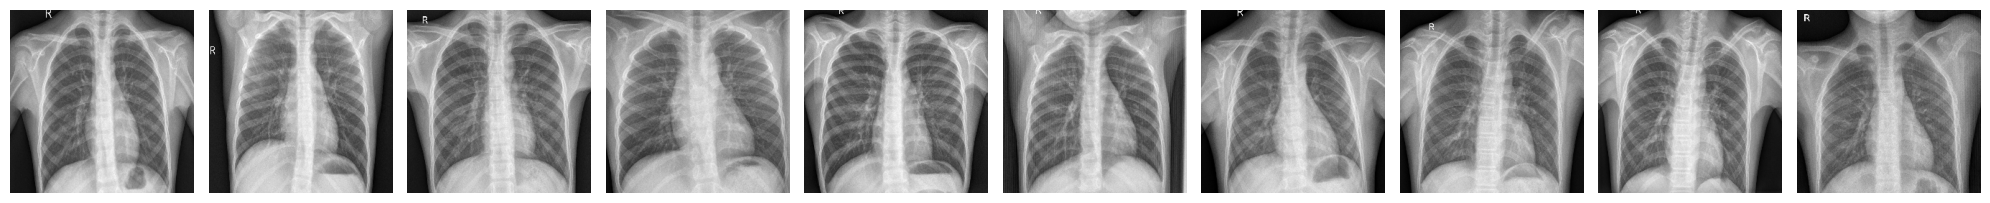

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [19]:
test_imgs, test_labels = next(test_generator)
plotImages(test_imgs)
print(test_labels)

In [20]:
predictions = model.predict(x=test_generator, verbose=0)

In [21]:
cm = confusion_matrix(y_true=test_generator.classes, y_pred=np.argmax(predictions0, axis=-1))

NameError: name 'predictions0' is not defined

In [ ]:
#Confusion matrix plot function from TensorFlows website
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    """
    A function to plot results in a confusion matrix.
    """
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j], horizontalalignment="center", color = "white" if cm[i,j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [ ]:
cm_plot_labels = ["Normal","viral_pneumonia", "bacterial_pneumonia"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title = "Confusion Matrix")